In [1]:
import plotly.express as px 
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt 

import pandas as pd 
import numpy as np
import os
import geopandas as gpd

import requests
from custom_function import *

# define api request header
os.environ['user-agent'] = "censusAPIBot/Version1.0.0 (org email)"
header = {"user-agent":os.getenv("user-agent")}

/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
<ipython-input-1-1c5cfe49bbd3>:9: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS dir

## Loading Geography Boundary
Using the boundaries shapefile listed on [ONS Open Geography Portal](https://geoportal.statistics.gov.uk), we will load the boundaries and the area code which will be useful when retrieving the Census data. Different dataset has data available at different geography level. In the section below, there is an extensive amount of code loading different geography. Depending on the use case, some geography that are not relevant are commented out. For comparison of the geography level available to the census data, see [Area Type Definition Census 2021](https://www.ons.gov.uk/census/census2021dictionary/areatypedefinitions#:~:text=Lower%20tier%20local%20authorities%20provide,(including%20City%20of%20London.)).

There exists multiple lookup table that will help us classify smaller geographical division into to the larger unit. These files, by nature are on-geographical. However, they are only available in the `.geojson` format. Therefore, we will use the `geoPandas` module to parse the data. 

**Note that using these API, there is a limit that each quuery would only return 1000 rows at maximum.**

In [2]:
# load the lookup table
lookup_table = gpd.read_file("https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/OA21_WD22_LTLA22_UTLA22_RGN22_CTRY22_EW_LU_v2/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

In [3]:
# get the regions of the uk
regions_E = gpd.read_file("https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Regions_December_2016_UGCB_in_England_2022/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")
# check the crs 
regions_E.crs
# reproject regions_E to British National Grid
# regions_E = regions_E.to_crs(epsg = 27700)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
# # get the msoa
# msoa = gpd.read_file("./data/MOSA_2021/")
# # check the crs 
# msoa.crs

In [5]:
# # get the westminster paliametary constituency of the uk
# wpc = gpd.read_file("https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Westminster_Parliamentary_Constituencies_Dec_2022_UK_BFC/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")
# # check the crs
# wpc.crs
# # reporject wpc to British National Grid
# # wpc = wpc.to_crs(epsg = 27700)

# # filter for England and Wales only
# wpc_EW = wpc[wpc['PCON22CD'].str.contains("[EW]")]

# # apply spatial join
# wpc_EW = wpc_EW.sjoin(regions_E[['rgn16nm','geometry']],how = "left")

# # fill in the rgn as Wales 
# wales_index = wpc_EW['PCON22CD'].str.contains("W")
# wpc_EW.loc[wales_index, 'rgn16nm'] = "Wales"

# # inspect result
# wpc_EW.sample(n=10)

# # inspect the number of WPC per region
# wpc_EW.groupby("rgn16nm").size()

In [6]:
# load the low tiered local authority boundary
ltla = gpd.read_file("https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Local_Authority_Districts_December_2011_FEB_EW_2022/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")
# check the crs
ltla.crs

# filter for England and Wales only
ltla_EW = ltla[ltla['lad11cd'].str.contains("[EW]")]

# spatial join to get the region
ltla_EW  = ltla_EW.sjoin(regions_E[['rgn16nm','geometry']],how = "left")

# fill in for wales
wales_ind = ltla_EW['lad11cd'].str.contains("W")
ltla_EW.loc[wales_ind, "rgn16nm"] = "Wales"

# inspect the result
ltla_EW.sample(n=10)


,OBJECTID,lad11cd,lad11cdo,lad11nm,lad11nmw,Shape__Area,Shape__Length,GlobalID,geometry,index_right,rgn16nm
142,143,E07000110,29UH,Maidstone,,3.933507e+08,121874.055888,d43e0ff2-046e-4597-a6c1-83c5283ab54c,"POLYGON ((0.57099 51.33634, 0.57135 51.33609, ...",7.0,South East
14,15,E06000015,00FK,Derby,,7.803113e+07,50037.612393,7dbd94ca-d724-48d9-aef6-f8c73d2de327,"POLYGON ((-1.48073 52.96805, -1.48052 52.96804...",3.0,East Midlands
192,193,E07000166,36UE,Richmondshire,,1.318707e+09,221709.949820,5ebac48e-d658-46a0-bc65-39266b5b1146,"POLYGON ((-1.69862 54.53610, -1.69834 54.53608...",2.0,Yorkshire and The Humber
139,140,E07000107,29UD,Dartford,,7.631042e+07,52447.140155,a061523b-c1b5-4bca-98d5-ec3914761170,"POLYGON ((0.22803 51.47989, 0.22821 51.47980, ...",7.0,South East
147,148,E07000115,29UP,Tonbridge and Malling,,2.409734e+08,109907.239851,793ce066-cdb1-4a59-a1d0-0014c343287c,"POLYGON ((0.47490 51.36070, 0.47568 51.36022, ...",7.0,South East
320,321,E09000028,00BE,Southwark,,2.991344e+07,33627.049876,489d6093-df6b-43f3-a24a-882a08e7eecb,"POLYGON ((-0.10556 51.50989, -0.10515 51.50988...",6.0,London
205,206,E07000179,38UD,South Oxfordshire,,6.785388e+08,205266.843703,b24b7a72-d23d-47a9-aad5-49bd90cd13bf,"POLYGON ((-1.16598 51.81214, -1.16568 51.81181...",7.0,South East
297,298,E09000005,00AE,Brent,,4.323264e+07,38334.036787,86d76495-459b-47af-ad7f-3d7bd2192450,"POLYGON ((-0.26474 51.59818, -0.26425 51.59778...",6.0,London
169,170,E07000137,32UC,East Lindsey,,1.828952e+09,214844.865058,f49fae6c-9497-443c-abbf-bfff7c80ef86,"POLYGON ((0.04253 53.52791, 0.04279 53.52788, ...",2.0,Yorkshire and The Humber
261,262,E08000005,00BQ,Rochdale,,1.580815e+08,82432.735190,573fcb32-df9e-45c6-a217-711c6028c964,"POLYGON ((-2.13225 53.68405, -2.13136 53.68370...",1.0,North West


In [7]:
# inspect the number of LTLA per region
ltla_EW.groupby("rgn16nm").size()

rgn16nm
East Midlands               66
East of England             62
London                      50
North East                  17
North West                  50
South East                  87
South West                  46
Wales                       24
West Midlands               44
Yorkshire and The Humber    42
dtype: int64

## Request Census API data - LITA
First we need to define the list of area code to request.
While we should be able to set chunk size to 50 to improve the running time, there API sometimes fails to render data for specific geography. For the sake of convenience, we will compromise on some lost data without too much drag on the running time by setting chunk size to 5.

In [8]:
# initialize the for loop
area_codes = list(ltla['lad11cd'])
area_type = "ltla"
chunksize = 5
n = 0
n_chunks = np.ceil(len(area_codes)/ chunksize)
area_chunks = np.array_split(area_codes, n_chunks)

dataset_id = "TS060"
version = 5
ts060 = pd.DataFrame()

for areas in area_chunks:
    # parse th chunk of area code
    new_data = requests_census2021_api(area_code = areas,area_type=area_type, datasetId=dataset_id, version = version)
    ts060 = pd.concat([ts060, new_data],ignore_index = True)


requesting https://api.beta.ons.gov.uk/v1/datasets/TS060/editions/2021/versions/5/json?area-type=ltla,E06000001,E06000002,E06000003,E06000004,E06000005
requesting https://api.beta.ons.gov.uk/v1/datasets/TS060/editions/2021/versions/5/json?area-type=ltla,E06000006,E06000007,E06000008,E06000009,E06000010
requesting https://api.beta.ons.gov.uk/v1/datasets/TS060/editions/2021/versions/5/json?area-type=ltla,E06000011,E06000012,E06000013,E06000014,E06000015
requesting https://api.beta.ons.gov.uk/v1/datasets/TS060/editions/2021/versions/5/json?area-type=ltla,E06000016,E06000017,E06000018,E06000019,E06000020
requesting https://api.beta.ons.gov.uk/v1/datasets/TS060/editions/2021/versions/5/json?area-type=ltla,E06000021,E06000022,E06000023,E06000024,E06000025
requesting https://api.beta.ons.gov.uk/v1/datasets/TS060/editions/2021/versions/5/json?area-type=ltla,E06000026,E06000027,E06000028,E06000029,E06000030
A 500 error occured when requesting the url
requesting https://api.beta.ons.gov.uk/v1/da

In [9]:
ts060.head()

,href,id,label,Does not apply,"01 Crop and animal production, hunting and related service activities",02 Forestry and logging,03 Fishing and aquaculture,05 Mining of coal and lignite,06 Extraction of crude petroleum and natural gas,07 Mining of metal ores,...,"90 Creative, arts and entertainment activities","91 Libraries, archives, museums and other cultural activities",92 Gambling and betting activities,93 Sports activities and amusement and recreation activities,94 Activities of membership organisations,95 Repair of computers and personal and household goods,96 Other personal service activities,97 Activities of households as employers of domestic personnel,98 Undifferentiated goods- and services-producing activities of private households for own use,99 Activities of extraterritorial organisations and bodies
0,,E06000001,Hartlepool,54589,117,0,32,5,401,2,...,139,61,113,277,145,22,575,8,0,1
1,,E06000002,Middlesbrough,87490,75,3,4,5,531,3,...,209,44,138,395,238,48,897,9,0,1
2,,E06000003,Redcar and Cleveland,80910,241,9,33,70,657,13,...,246,113,134,503,174,51,1045,14,0,2
3,,E06000004,Stockton-on-Tees,110152,245,7,7,9,863,5,...,351,94,211,790,297,44,1429,11,0,2
4,,E06000005,Darlington,58503,297,12,2,2,107,0,...,201,75,61,466,190,56,773,12,0,2


Let's retrieve data from the TS058 dataset with the same process.

In [10]:
# initialize the for loop
area_codes = list(ltla['lad11cd'])
area_type = "ltla"
chunksize = 5
n = 0
n_chunks = np.ceil(len(area_codes)/ chunksize)
area_chunks = np.array_split(area_codes, n_chunks)

dataset_id = "TS058"
version = 4
ts058 = pd.DataFrame()

for areas in area_chunks:
    # parse th chunk of area code
    new_data = requests_census2021_api(area_code = areas,area_type=area_type, datasetId=dataset_id, version = version)
    ts058 = pd.concat([ts058, new_data],ignore_index = True)

requesting https://api.beta.ons.gov.uk/v1/datasets/TS058/editions/2021/versions/4/json?area-type=ltla,E06000001,E06000002,E06000003,E06000004,E06000005
requesting https://api.beta.ons.gov.uk/v1/datasets/TS058/editions/2021/versions/4/json?area-type=ltla,E06000006,E06000007,E06000008,E06000009,E06000010
requesting https://api.beta.ons.gov.uk/v1/datasets/TS058/editions/2021/versions/4/json?area-type=ltla,E06000011,E06000012,E06000013,E06000014,E06000015
requesting https://api.beta.ons.gov.uk/v1/datasets/TS058/editions/2021/versions/4/json?area-type=ltla,E06000016,E06000017,E06000018,E06000019,E06000020
requesting https://api.beta.ons.gov.uk/v1/datasets/TS058/editions/2021/versions/4/json?area-type=ltla,E06000021,E06000022,E06000023,E06000024,E06000025
requesting https://api.beta.ons.gov.uk/v1/datasets/TS058/editions/2021/versions/4/json?area-type=ltla,E06000026,E06000027,E06000028,E06000029,E06000030
A 500 error occured when requesting the url
requesting https://api.beta.ons.gov.uk/v1/da

In [11]:
ts058.head()

,href,id,label,Does not apply,Less than 2km,2km to less than 5km,5km to less than 10km,10km to less than 20km,20km to less than 30km,30km to less than 40km,40km to less than 60km,60km and over,Works mainly from home,"Works mainly at an offshore installation, in no fixed place, or outside the UK"
0,,E06000001,Hartlepool,54589,5891,7286,3159,5623,1779,575,363,711,6570,5792
1,,E06000002,Middlesbrough,87490,7933,13055,9102,3755,1427,833,676,1069,9478,9106
2,,E06000003,Redcar and Cleveland,80910,5697,6555,9153,9990,1906,1002,814,1251,10019,9234
3,,E06000004,Stockton-on-Tees,110152,9414,14069,16003,9943,2085,1097,1208,1561,18809,12254
4,,E06000005,Darlington,58503,8070,9043,3522,4531,3828,524,737,850,11962,6230


## Data Manipulation
The objective is to create two sets of continuous data that can be used as to create a scatter plot.
With a scatter plot, we can leverage on four dimensions
* TS060_pct: X varaible
* TS058_pct: Y varaible
* Total pop: Size
* Color: Region

For the travel time, let's compute the percentage of the local workforce population who has to commute more than 20 km for work.

In [12]:
ts058_new = ts058.copy()
ts058_new['Work Force Population'] = ts058_new.select_dtypes("integer").sum(axis = 1) - ts058_new['Does not apply'] - ts058_new['Works mainly at an offshore installation, in no fixed place, or outside the UK']
ts058_new["20km or More"] = ts058[["20km to less than 30km","30km to less than 40km",'40km to less than 60km', '60km and over']].sum(axis = 1)
ts058_new['% 20km or More'] = ts058_new["20km or More"] / ts058_new['Work Force Population'] 

To aggregate the popultion by employment sector, we will use the four tier system:
* Primary Industry - Agriculture, Forestry and Fishing: 01 - 03
* Production and Manufacturing: 05-33
* Utility (Gase, water etc.): 35 - 39
* Construction: 41-43
* Service: 45-99

**Note** dimension 04, 40, 44 and potentially 100 or 00 is missing from the list. These potentially are the aggregate for the level of industry. However, there is no documentation on how to retrieve those.

In [13]:
ts060_new = ts060.copy().drop(columns = ['Does not apply'])
ts060_new = ts060_new.select_dtypes("integer")

In [14]:
# convert the column to the 2 digit index
cols = ts060_new.columns
cols = [col[0:2] for col in cols]
ts060_new.columns = cols

# create the industry column index 
prim = [str(ind).zfill(2) for ind in np.arange(1,4,)]
prod = [str(ind).zfill(2) for ind in np.arange(5,34)]
util = [str(ind).zfill(2) for ind in np.arange(35,40)]
cons = ["41"]
serv = [str(ind).zfill(2) for ind in np.arange(45,100) if ((ind!= 54) & (ind!= 57) & (ind!= 67) & (ind!= 76)& (ind!= 83) &  (ind!= 89))]

# get total working population
ts060_new["Work Force Population"] = ts060_new.sum(axis = 1)
# get industry aggregate
ts060_new["Prim"] = ts060_new[prim].sum(axis = 1) / ts060_new["Work Force Population"]
ts060_new["Prod"] = ts060_new[prod].sum(axis = 1) /ts060_new["Work Force Population"]
ts060_new["Util"] = ts060_new[util].sum(axis = 1) /ts060_new["Work Force Population"]
ts060_new["Cons"] = ts060_new[cons].sum(axis = 1) /ts060_new["Work Force Population"]
ts060_new["Serv"] = ts060_new[serv].sum(axis = 1) /ts060_new["Work Force Population"]

# add back the id col
ts060_new = ts060[['id']].merge(ts060_new, left_index= True, right_index=True)

## Merging the Data
We only really want the aggregate here. Before merging, define the right and left table as a subset of the original table.

In [15]:
# subset the dataframe
left_ts058 = ts058_new[["id","Work Force Population","% 20km or More"]]
right_ts060 = ts060_new[["id", "Work Force Population","Prim","Prod","Util","Cons","Serv"]]

# merge the dataframe
df = left_ts058.merge(right_ts060, on = 'id', suffixes = ("_l","_r"))

# lookup the region name
df = df.merge(ltla_EW[["lad11cd","lad11nm","rgn16nm"]], left_on = 'id', right_on= "lad11cd", how = 'left')

In [16]:
df.head()

,id,Work Force Population_l,% 20km or More,Work Force Population_r,Prim,Prod,Util,Cons,Serv,lad11cd,lad11nm,rgn16nm
0,E06000001,31957,0.107269,37749,0.003947,0.113963,0.027233,0.100903,0.753954,E06000001,Hartlepool,North East
1,E06000002,47328,0.084622,56431,0.001453,0.081391,0.014815,0.085006,0.817334,E06000002,Middlesbrough,Yorkshire and The Humber
2,E06000002,47328,0.084622,56431,0.001453,0.081391,0.014815,0.085006,0.817334,E06000002,Middlesbrough,North East
3,E06000003,46387,0.107207,55620,0.005088,0.101798,0.018051,0.096854,0.778209,E06000003,Redcar and Cleveland,Yorkshire and The Humber
4,E06000003,46387,0.107207,55620,0.005088,0.101798,0.018051,0.096854,0.778209,E06000003,Redcar and Cleveland,North East


Note that there are some big differences in the two estimate of the work force population. Since the commute distance dataframe maybe more relevant to the geographical location that serves as a layer of disaggregation for this data set, we will use the work force population generated form the TS058 dataset.

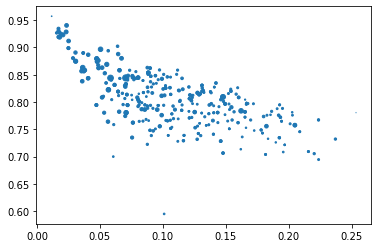

In [17]:
# inspect plot with matplotlib
plt.scatter(x = df['% 20km or More'], y = df["Serv"], 
            s =df['Work Force Population_l']/10000,
        )

In [18]:
# get the list of region
rgn16nm = list(ltla_EW["rgn16nm"].sort_values().unique())

# instantiate figure
fig = go.Figure()
# instantiate drop-down button
keys = ["label","method","args"]
vals = ["All","update",
            [{"visible":[True for _ in range(len(rgn16nm))]}]
        ]

dropdown_button =[dict(zip(keys,vals))]
n = 0
# for loop to add trace an label
for group in rgn16nm:
    # get the regional subset
    df_subset = df[df['rgn16nm'] ==  group]

    # transform the size
    size = [max(size, 5) for size in df_subset['Work Force Population_l'] /10000]
    # size = np.arctan(df_subset['Work Force Population_l']/df['Work Force Population_l'].max()) * 60
    # size = np.log(df_subset["Work Force Population_l"]) * 0.8



    # add trace
    scatter_trace = go.Scatter(x=df_subset['% 20km or More'], y=df_subset['Serv'], name=group,
                                text = df_subset['lad11nm'],
                                mode = "markers",
                                marker = dict(size=size,opacity=0.5),
                                # define hover text
                                hovertemplate=
                                    "<b>%{text}</b><br>" +
                                    "Population: %{customdata:.2s}" +
                                    "<extra></extra>",
                                customdata = df_subset['Work Force Population_l']
                            )
    fig.add_trace(scatter_trace )
    # add drop_down button
    visible = [False for _ in range(len(rgn16nm))]
    visible[n] = True
    vals = [group,"update", [{"visible":visible}]]
    button = dict(zip(keys,vals))
    dropdown_button.append(button)
    n +=1

# Customize the legend appearance
fig.update_layout(
    legend=dict(
        itemsizing='constant'  # Set the size of legend markers to be constant
    ),
    plot_bgcolor='rgba(245, 250, 250, 100)'
)

# add drop_down button
fig.update_layout({
'updatemenus':[{
'type': "dropdown",
'x': 1,
'y': 1,
'showactive': True,
'active': 0,
'buttons': dropdown_button}]
})

# add axis title
fig.update_layout(
    title = "Employment and Distance Travelled to Work",
    xaxis={
        'title':'Population with Long Commute',
        'tickformat':"2%"
        },
    yaxis={'title':'Population Employed to Service Sector',
           'tickformat':"2%"})

fig.show()

In [19]:
pio.write_html(fig, file=f'./output/ts058_ts060_v1.html', auto_open=True)

In [20]:
dir(fig.data[0].marker)

['_BasePlotlyType__validators',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_repr_for_class',
 '_change_callbacks',
 '_compound_array_props',
 '_compound_props',
 '_dispatch_change_callbacks',
 '_get_child_prop_defaults',
 '_get_child_props',
 '_get_prop_validator',
 '_get_validator',
 '_in_batch_mode',
 '_init_child_props',
 '_init_props',
 '_mapped_properties',
 '_orphan_props',
 '_parent',
 '_parent_path_str',
 '_path_str',
 '_plotly_name',
 '_process_kwargs',
 '_prop_defaults',
 '_prop_descriptions',
 '_prop_set_child',
 '_props',
 '_raise_on_invalid_property_error',
 '_relayout_child',
 '_res

In [29]:
# get the list of region
rgn16nm = list(ltla_EW["rgn16nm"].sort_values().unique())

# instantiate figure
fig = go.Figure()
# instantiate drop-down button
keys = ["label","method","args"]
vals = ["All","update",
            [{"marker.color":px.colors.qualitative.Plotly}]
        ]

dropdown_button =[dict(zip(keys,vals))]
n = 0
# for loop to add trace an label
for group in rgn16nm:
    # get the regional subset
    df_subset = df[df['rgn16nm'] ==  group]

    # transform the size
    size = [max(size, 5) for size in df_subset['Work Force Population_l'] /10000]
    # size = np.arctan(df_subset['Work Force Population_l']/df['Work Force Population_l'].max()) * 60
    # size = np.log(df_subset["Work Force Population_l"]) * 0.8



    # add trace
    scatter_trace = go.Scatter(x=df_subset['% 20km or More'], y=df_subset['Serv'], name=group,
                                text = df_subset['lad11nm'],
                                mode = "markers",
                                marker = dict(size=size,opacity=0.5),
                                # define hover text
                                hovertemplate=
                                    "<b>%{text}</b><br>" +
                                    "Population: %{customdata:.2s}" +
                                    "<extra></extra>",
                                customdata = df_subset['Work Force Population_l']
                            )
    fig.add_trace(scatter_trace )
    # add drop_down button
    color = ['rgba(150, 150, 150, 10)' for _ in range(len(rgn16nm))]
    color[n] = 'rgba(241, 156, 121, 240)'
    vals = [group,"update", [{"marker.color":color}]]
    button = dict(zip(keys,vals))
    dropdown_button.append(button)
    n +=1

# Customize the legend appearance
fig.update_layout(
    legend=dict(
        itemsizing='constant'  # Set the size of legend markers to be constant
    ),
    plot_bgcolor='rgba(245, 250, 250, 100)',
   
)

# add drop_down button
fig.update_layout({
'updatemenus':[{
'type': "dropdown",
'x': 1,
'y': 1,
'showactive': True,
'active': 0,
'buttons': dropdown_button}]
})

# add axis title
fig.update_layout(
    title = "Employment and Distance Travelled to Work",
    xaxis={
        'title':'Population with Long Commute',
        'tickformat':"2%"
        },
    yaxis={'title':'Employed to Service Sector',
           'tickformat':"2%"})

fig.show()

In [30]:
pio.write_html(fig, file=f'./output/ts058_ts060_v2.html', config={"responsive": True}, auto_open=True)

In [26]:
print(px.colors.qualitative.Plotly)

['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
